<h1>Содержание<span class="tocSkip"></span></h1>
<br>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#1-Подготовка-окружения">
                    <span class="toc-item-num">1&nbsp;&nbsp;</span>
                    Подготовка окружения
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#2-Загрузка-данных">
                    <span class="toc-item-num">2&nbsp;&nbsp;</span>
                    Загрузка данных
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#3-Двунаправленная-LSTM">
                    <span class="toc-item-num">3&nbsp;&nbsp;</span>
                    Двунаправленная LSTM
                </a>
            </span>
            <ul class="toc-item">
                <li>
                    <span>
                        <a href="#3.1-Токенизация-слов">
                            <span class="toc-item-num">3.1&nbsp;&nbsp;</span>
                            Токенизация слов
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.2-Подготовка-модели">
                            <span class="toc-item-num">3.2&nbsp;&nbsp;</span>
                            Подготовка модели
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.3-Обучение-модели">
                            <span class="toc-item-num">3.3&nbsp;&nbsp;</span>
                            Обучение модели
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.4-Генерация-текста">
                            <span class="toc-item-num">3.4&nbsp;&nbsp;</span>
                            Генерация текста
                        </a>
                    </span>
                </li>
            </ul>
        </li>
        <li>
            <span>
                <a href="#4-Общий-вывод">
                    <span class="toc-item-num">4&nbsp;&nbsp;</span>
                    Общий вывод
                </a>
            </span>
        </li>
    </ul>
</div>

# Генеративные текстовые нейросети | Двунаправленная LSTM

**Постановка задачи:** натренировать и сравнить качество нескольких генеративных текстовых моделей на одном из заданных текстовых датасетов.

**Источник данных:** [Harry Potter and the Methods of Rationality](https://hpmor.ru/).

**Характер данных:** текст книги "Гарри Поттер и методы рационального мышления".

**Основные этапы:** исследовать следующие нейросетевые архитектуры:

1. Simple RNN с посимвольной и пословной токенизацией.
2. Однонаправленная однослойная и многослойная LSTM c посимвольной токенизацией и токенизацией по словам и [на основе BPE](https://keras.io/api/keras_nlp/tokenizers/byte_pair_tokenizer/).
3. Двунаправленная LSTM.
4. *(На хорошую оценку)* трансформерная архитектура (GPT) "с нуля" [пример](https://keras.io/examples/generative/text_generation_gpt/).
5. *(На отличную оценку)* дообучение предобученной GPT-сети [пример](https://github.com/ZotovaElena/RuGPT3_finetuning).

---

# Реализации

1. [RNN с посимвольной токенизацией](RNN_char.ipynb)
2. [RNN с пословной токенизацией](RNN_word.ipynb)
3. [Однонаправленная LSTM + BPE](LSTM_unidirectional_BPE.ipynb)
4. Двунаправленная LSTM (текущий файл)
5. [Архитектура GPT](GPT_architecture.ipynb)
6. [Дообучение GPT](GPT_finetuning.ipynb)

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 1 Подготовка окружения

Импорт библиотек:

In [1]:
import numpy as np
import os

from tensorflow import keras
from tensorflow.keras.preprocessing import sequence

import keras.layers as l

from keras import models, callbacks, utils
from keras.preprocessing import text

# custom funcs
import utils.web_scrapping as web
import utils.process_checking as check
import utils.data_preprocessing as data_prep
import utils.charts_plotting as chart

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Загрузка данных

Формирование/загрузка набора данных в зависимости от его наличия:

In [2]:
data = web.load_data('https://hpmor.ru/', 'hpmor.txt')

Uploaded from data/hpmor.txt


Выведение на экран начала текста:

In [3]:
data[:500]

'гарри поттер и методы рационального мышления. элиезер юдковский (less wrong). петуния вышла замуж не за дурсля, а за университетского профессора, и гарри попал в гораздо более благоприятную среду. у него были частные учителя, дискуссии с отцом, а главное — книги, сотни и тысячи научных и фантастических книг. в 11 лет гарри знаком с квантовой механикой, когнитивной психологией, теорией вероятностей и другими вещами. но гарри не просто вундеркинд, у него есть загадочная тёмная сторона, которая явн'

Выведение на экран общего числа слов и предложений в тексте:

In [4]:
check.print_total(data)

Всего слов: 559791
Всего предложений: 37351


Разделение текста на отдельные предложения:

In [5]:
data_sentences = data_prep.split_into_sentences(data)

Выведение на экран начала текста:

In [6]:
data_sentences[:5]

['гарри поттер и методы рационального мышления',
 'элиезер юдковский',
 'петуния вышла замуж не за дурсля, а за университетского профессора, и гарри попал в гораздо более благоприятную среду',
 'у него были частные учителя, дискуссии с отцом, а главное  книги, сотни и тысячи научных и фантастических книг',
 'в 11 лет гарри знаком с квантовой механикой, когнитивной психологией, теорией вероятностей и другими вещами']

Сокращение количества предложений для обеспечения работы модели:

In [7]:
data_sentences = data_sentences[:500]

Выведение на экран количества слов в уменьшенном тексте:

In [8]:
check.print_total(' '.join(data_sentences))

Всего слов: 6670


<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 3 Двунаправленная LSTM

### 3.1 Токенизация слов

Объявление объекта токенизатора:

In [9]:
tokenizer = text.Tokenizer()

Токенизация предложений:

In [10]:
tokenizer.fit_on_texts(data_sentences)

Выведение на экран количества токенов в словаре:

In [11]:
print('Всего слов:', len(tokenizer.word_index))

Всего слов: 2890


Выведение на экран начала словаря токенов:

In [12]:
check.print_tokenizer_vocabulary(tokenizer.word_index)

[('в', 1),
 ('и', 2),
 ('не', 3),
 ('что', 4),
 ('гарри', 5),
 ('я', 6),
 ('на', 7),
 ('с', 8),
 ('но', 9),
 ('это', 10)]

Формирование признаков:

In [13]:
features = data_prep.get_features(data_sentences, tokenizer)

Выведение на экран начала признаков:

In [14]:
features[:10]

[[5, 26],
 [5, 26, 2],
 [5, 26, 2, 272],
 [5, 26, 2, 272, 273],
 [5, 26, 2, 272, 273, 274],
 [780, 781],
 [54, 782],
 [54, 782, 783],
 [54, 782, 783, 3],
 [54, 782, 783, 3, 21]]

Задание констант:

In [15]:
VOCAB_LEN = len(tokenizer.word_index) + 1
MAX_SEQ_LEN = max([len(x) for x in features])
BATCH_SIZE = 100

Преобразование признаков:

In [16]:
features = np.array(sequence.pad_sequences(features, maxlen=MAX_SEQ_LEN, padding='pre'))

Задание признаков и целевого признака:

In [17]:
features, target = features[:,:-1], features[:,-1]
target = utils.to_categorical(target, num_classes=VOCAB_LEN)

Выведение на экран экземпляра признаков и целевого признака:

In [18]:
check.print_single_element(features, target, tokenizer.index_word)

Признаки (68,):
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0  29  14 263 265  48 744]

Перевод в текст:
профессор макгонагалл вздохнула ваши родители ваша

Целевой признак (2891,):
76

Перевод в текст:
мать



---

### 3.2 Подготовка модели

Задание модели:

In [19]:
model = models.Sequential([
    l.Embedding(VOCAB_LEN, BATCH_SIZE, input_length=MAX_SEQ_LEN-1),
    l.Bidirectional(l.LSTM(150, return_sequences=True)),
    l.Dropout(0.2),
    l.LSTM(100),
    l.Dense(VOCAB_LEN / 2, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    l.Dense(VOCAB_LEN, activation='softmax')
])

Выведение на экран таблицы поведения параметров на слоях нейросети:

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 68, 100)           289100    
                                                                 
 bidirectional (Bidirectiona  (None, 68, 300)          301200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 68, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1445)              145945    
                                                                 
 dense_1 (Dense)             (None, 2891)              4180386   
                                                        

Проверка наличия папки для хранения изображений:

In [21]:
if os.path.isdir('images/') == False:
    os.mkdir('images/')

Выведение на экран отображения послойной обработки данных моделью:

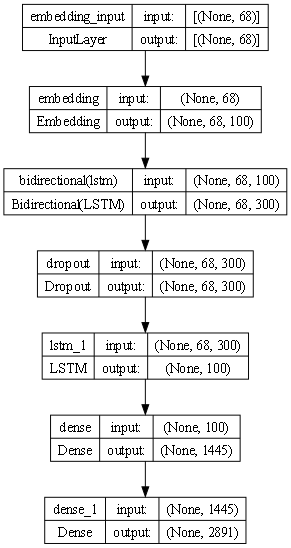

In [22]:
utils.plot_model(model, 'images/lstm_bi_model.png', show_shapes=True, dpi=70)

---

### 3.3 Обучение модели

Проверка наличия папки для хранения контрольных точек:

In [23]:
if os.path.isdir('checkpoints/') == False:
    os.mkdir('checkpoints/')

Задание пути для хранения контрольных точек:

In [24]:
path_checkpoints = 'checkpoints/lstm_bi'

Проверка наличия папки для хранения контрольных точек:

In [25]:
if os.path.isdir(path_checkpoints) == False:
    os.mkdir(path_checkpoints)

Задание коллбека точек сохранения:

In [26]:
checkpoint_path = os.path.join(path_checkpoints, 'checkpoint_{epoch}')

checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    save_weights_only=True, 
    verbose=1
)

Подготовка модели к обучению:

In [27]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Обучение модели:

In [28]:
history = model.fit(
    features, 
    target, 
    epochs=200,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/200
195/195 [==============================] - ETA: 0s - loss: 7.7774 - accuracy: 0.0236
Epoch 1: saving model to checkpoints/lstm_bi\checkpoint_1
195/195 [==============================] - 50s 241ms/step - loss: 7.7774 - accuracy: 0.0236
Epoch 2/200
195/195 [==============================] - ETA: 0s - loss: 7.1167 - accuracy: 0.0263
Epoch 2: saving model to checkpoints/lstm_bi\checkpoint_2
195/195 [==============================] - 48s 246ms/step - loss: 7.1167 - accuracy: 0.0263
Epoch 3/200
195/195 [==============================] - ETA: 0s - loss: 6.9280 - accuracy: 0.0266
Epoch 3: saving model to checkpoints/lstm_bi\checkpoint_3
195/195 [==============================] - 56s 288ms/step - loss: 6.9280 - accuracy: 0.0266
Epoch 4/200
195/195 [==============================] - ETA: 0s - loss: 6.8419 - accuracy: 0.0254
Epoch 4: saving model to checkpoints/lstm_bi\checkpoint_4
195/195 [==============================] - 52s 266ms/step - loss: 6.8419 - accuracy: 0.0254
Epoch 5/200


Epoch 34/200
195/195 [==============================] - ETA: 0s - loss: 4.5046 - accuracy: 0.1531
Epoch 34: saving model to checkpoints/lstm_bi\checkpoint_34
195/195 [==============================] - 43s 222ms/step - loss: 4.5046 - accuracy: 0.1531
Epoch 35/200
195/195 [==============================] - ETA: 0s - loss: 4.4815 - accuracy: 0.1550
Epoch 35: saving model to checkpoints/lstm_bi\checkpoint_35
195/195 [==============================] - 45s 231ms/step - loss: 4.4815 - accuracy: 0.1550
Epoch 36/200
195/195 [==============================] - ETA: 0s - loss: 4.4013 - accuracy: 0.1635
Epoch 36: saving model to checkpoints/lstm_bi\checkpoint_36
195/195 [==============================] - 43s 220ms/step - loss: 4.4013 - accuracy: 0.1635
Epoch 37/200
195/195 [==============================] - ETA: 0s - loss: 4.2916 - accuracy: 0.1743
Epoch 37: saving model to checkpoints/lstm_bi\checkpoint_37
195/195 [==============================] - 43s 219ms/step - loss: 4.2916 - accuracy: 0.1743


Epoch 67/200
195/195 [==============================] - ETA: 0s - loss: 2.3812 - accuracy: 0.5601
Epoch 67: saving model to checkpoints/lstm_bi\checkpoint_67
195/195 [==============================] - 44s 227ms/step - loss: 2.3812 - accuracy: 0.5601
Epoch 68/200
195/195 [==============================] - ETA: 0s - loss: 2.3104 - accuracy: 0.5789
Epoch 68: saving model to checkpoints/lstm_bi\checkpoint_68
195/195 [==============================] - 45s 232ms/step - loss: 2.3104 - accuracy: 0.5789
Epoch 69/200
195/195 [==============================] - ETA: 0s - loss: 2.2455 - accuracy: 0.5919
Epoch 69: saving model to checkpoints/lstm_bi\checkpoint_69
195/195 [==============================] - 45s 233ms/step - loss: 2.2455 - accuracy: 0.5919
Epoch 70/200
195/195 [==============================] - ETA: 0s - loss: 2.1904 - accuracy: 0.6052
Epoch 70: saving model to checkpoints/lstm_bi\checkpoint_70
195/195 [==============================] - 47s 243ms/step - loss: 2.1904 - accuracy: 0.6052


Epoch 100/200
195/195 [==============================] - ETA: 0s - loss: 1.3163 - accuracy: 0.8103
Epoch 100: saving model to checkpoints/lstm_bi\checkpoint_100
195/195 [==============================] - 44s 228ms/step - loss: 1.3163 - accuracy: 0.8103
Epoch 101/200
195/195 [==============================] - ETA: 0s - loss: 1.2730 - accuracy: 0.8145
Epoch 101: saving model to checkpoints/lstm_bi\checkpoint_101
195/195 [==============================] - 46s 234ms/step - loss: 1.2730 - accuracy: 0.8145
Epoch 102/200
195/195 [==============================] - ETA: 0s - loss: 1.2316 - accuracy: 0.8288
Epoch 102: saving model to checkpoints/lstm_bi\checkpoint_102
195/195 [==============================] - 48s 246ms/step - loss: 1.2316 - accuracy: 0.8288
Epoch 103/200
195/195 [==============================] - ETA: 0s - loss: 1.2102 - accuracy: 0.8331
Epoch 103: saving model to checkpoints/lstm_bi\checkpoint_103
195/195 [==============================] - 45s 233ms/step - loss: 1.2102 - accur

195/195 [==============================] - 50s 257ms/step - loss: 0.5947 - accuracy: 0.9279
Epoch 165/200
195/195 [==============================] - ETA: 0s - loss: 0.6022 - accuracy: 0.9286
Epoch 165: saving model to checkpoints/lstm_bi\checkpoint_165
195/195 [==============================] - 50s 256ms/step - loss: 0.6022 - accuracy: 0.9286
Epoch 166/200
195/195 [==============================] - ETA: 0s - loss: 0.5906 - accuracy: 0.9305
Epoch 166: saving model to checkpoints/lstm_bi\checkpoint_166
195/195 [==============================] - 51s 261ms/step - loss: 0.5906 - accuracy: 0.9305
Epoch 167/200
195/195 [==============================] - ETA: 0s - loss: 0.5809 - accuracy: 0.9315
Epoch 167: saving model to checkpoints/lstm_bi\checkpoint_167
195/195 [==============================] - 52s 266ms/step - loss: 0.5809 - accuracy: 0.9315
Epoch 168/200
195/195 [==============================] - ETA: 0s - loss: 0.5765 - accuracy: 0.9303
Epoch 168: saving model to checkpoints/lstm_bi\che

195/195 [==============================] - ETA: 0s - loss: 0.4804 - accuracy: 0.9390
Epoch 197: saving model to checkpoints/lstm_bi\checkpoint_197
195/195 [==============================] - 48s 246ms/step - loss: 0.4804 - accuracy: 0.9390
Epoch 198/200
195/195 [==============================] - ETA: 0s - loss: 0.4674 - accuracy: 0.9430
Epoch 198: saving model to checkpoints/lstm_bi\checkpoint_198
195/195 [==============================] - 47s 239ms/step - loss: 0.4674 - accuracy: 0.9430
Epoch 199/200
195/195 [==============================] - ETA: 0s - loss: 0.4685 - accuracy: 0.9393
Epoch 199: saving model to checkpoints/lstm_bi\checkpoint_199
195/195 [==============================] - 48s 245ms/step - loss: 0.4685 - accuracy: 0.9393
Epoch 200/200
195/195 [==============================] - ETA: 0s - loss: 0.5662 - accuracy: 0.9186
Epoch 200: saving model to checkpoints/lstm_bi\checkpoint_200
195/195 [==============================] - 47s 243ms/step - loss: 0.5662 - accuracy: 0.9186


Выведение на экран графика значений функции потерь и качества модели:

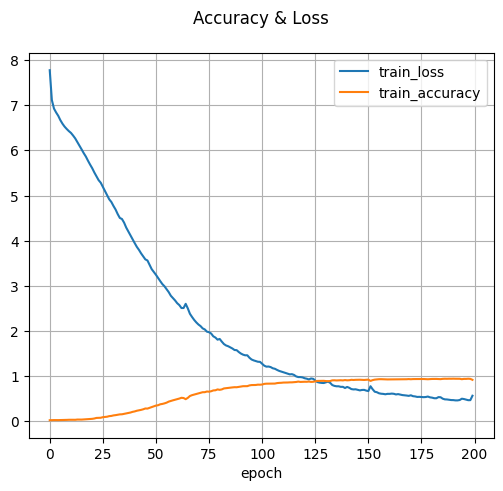

In [29]:
chart.plot_loss_acc(history)

Сброс состояния модели:

In [30]:
model.reset_states()

---

### 3.4 Генерация текста

Задание функции предсказания следующего слова:

In [ ]:
def predict_next_word(sample: str,
                      model: models.Sequential,
                      tokenizer: text.Tokenizer,
                      n_words: int,
                      max_len: int) -> str:
    
    generated = sample
    
    for _ in range(n_words):
        token_list = tokenizer.texts_to_sequences([generated])[0]
        token_list = sequence.pad_sequences([token_list], maxlen=max_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted = np.argmax(predicted)
        
        next_word = ''
        
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                next_word = word
                break
                
        generated += ' ' + next_word
    
    return generated

---

Выведение на экран результата предсказаний:

In [31]:
predict_next_word(
    sample='гарри поттер',
    model=model,
    tokenizer=tokenizer,
    n_words=100,
    max_len=MAX_SEQ_LEN
)

'гарри поттер и методы рационального мышления занимали первые места по популярности в мире среди всех фанфиков по гарри поттеру место варьировалось между первым и третьим в зависимости от метода подсчёта по числу отзывов или числу подписчиков станет печальное которые продемонстрировал поняли что существует они пять о вашей способности мыслить здраво именно тогда когда это больше всего необходимо обговорить все детали вашего поступления в хогвартс посмотрим прилетит ли сова чтобы забрать его жена миссис петуния эванс веррес а также их приёмный сын гарри джеймс поттер эванс веррес глазки постоянный длина и дарли гпимрм историю кого грянул постоянный курс не становилось бы невозможным перевод'

Выведение на экран результата предсказаний:

In [32]:
predict_next_word(
    sample='однажды в зачарованном лесу',
    model=model,
    tokenizer=tokenizer,
    n_words=100,
    max_len=MAX_SEQ_LEN
)

'однажды в зачарованном лесу моих биологических сутках двадцать шесть часов я каждый день ложусь спать на два часа позже чем человек в банке всё проблемы на том кого нельзя называть тёмном лорде волдеморте чем такой ещё при нарушении закона сохранения теряется унитарность получается распространение сигналов быстрее скорости света и кошки сложные человеческий разум просто не в состоянии представить себе всю кошачью анатомию и всю кошачью биохимию не говоря уже о неврологии есть чем лежит письмо момент себя рассказать одно правило последний судья это наблюдение происходит и лучше может быть правдой защиту от тёмных искусств творение в маленькую сном кто чистой ненависти и бьёт прямо'

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 4 Общий вывод

В ходе исследования была построена модель нейросети, основанная на слое двунаправленной LSTM для обеспечения ей временной памяти. Модель продемонстрировала любопытные результаты предсказания следующего слова на основе заданного ей запроса. Результат можно улучшить, увеличив количество обрабатываемых данных, однако это возможно только при наличии удовлетворяющих задаче технических средств.

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>